In [1]:
import pandas as pd
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader,SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torchvision import transforms as tfs
from PIL import Image
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import time
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

In [2]:
gpu_boole = torch.cuda.is_available()
print(gpu_boole) ##If True, then your GPU is enabled and you are able to make use of it

False


In [3]:
m = nn.Conv1d(16, 33, 3, stride=2)
input = torch.randn(30, 3).reshape(3,30)
input.shape

torch.Size([3, 30])

## Load data


In [36]:
url = "https://raw.githubusercontent.com/shreyasingh1/epilepsypcm/shreya/experiments/newDF.csv"
dataset = pd.read_csv(url).drop(['Unnamed: 0','Channels'], axis = 1) 
dataset = dataset.drop(labels =1)
df_train, df_test = train_test_split(dataset,test_size=0.22, random_state=100)
y_train = torch.Tensor(df_train['outcome'].to_numpy())
x_train = torch.Tensor(df_train.drop(['outcome'], axis = 1).to_numpy())
y_test = torch.Tensor(df_test['outcome'].to_numpy())
x_test = torch.Tensor(df_test.drop(['outcome'], axis = 1).to_numpy())
# dataloaders:
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)
TRAIN_BATCH_SIZE = 2
TEST_BATCH_SIZE = 2
train_dataloader = torch.utils.data.DataLoader(train, batch_size=TRAIN_BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=TEST_BATCH_SIZE, shuffle=False)
x_train.shape

torch.Size([240, 14])

## Model

In [68]:
class CNNet(nn.Module):
    
    """
    
    """
    
    def __init__(self,input_size=2):
        """
        
        """
        ## Inherent Torch Module
        super(CNNet, self).__init__()

        ##TODO: Initialize Model Layers
        self.layer1 = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.ff = nn.Linear(256, 32)
        self.fc = nn.Linear(32, input_size)
        self.sof= nn.Softmax()
    def forward(self, input_data):
        """
        
        """
        ##TODO: Setup Forward Pass
        out = self.layer1(input_data)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.ff(out)
        out = self.fc(out)
        out = self.sof(out)
        return out


In [69]:
def eval_cnn(loader, verbose = 1):
    '''
    This function caculate for accuracy and loss. 
    Code reference: 601.482/682 Deep Learning L9
    '''
    correct = 0
    loss_sum = 0
    total = 0
    for images, labels in loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        x_new = torch.dstack((images,images))
        x_new = x_new.permute(2,0,1)
        y = labels.to(torch.int64)
        outputs = model(x_new)
        loss_sum += loss_f(outputs,y)
        total += y.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted.float() == labels.float()).sum()
    if verbose:
        if loader == train_dataloader:
            print('Train accuracy: %f %%' % (100.0 * correct / total))
            print('Train loss: %f' % (loss_sum.cpu().data.numpy().item() / total))
        elif loader == test_dataloader:
            print('Test accuracy: %f %%' % (100.0 * correct / total))
            print('Test loss: %f' % (loss_sum.cpu().data.numpy().item() / total))
    
    return 100.0 * correct.cpu().data.numpy().item() / total, loss_sum.cpu().data.numpy().item() / total
    
    

## Train

In [83]:
def train_cnn(model,
          optimizer,
          loss_metric,
          lr,
          epochs=50,
          train_dataloader=train_dataloader,
          test_dataloader=test_dataloader,
          **kwargs):
    """
    
    """
    ##TODO: Implement a training loop

    #defining train loss & train/test/validation accuracy recording arrays for later visualization/plotting:
    train_loss_store = []
    train_perc_store = []
    val_perc_store = []
    test_perc_store = []

    print("Starting Training")
    #training loop:
    m = 0
    for epoch in range(epochs):
        time1 = time.time() #timekeeping
        verbose = 0
        for i, (x,y) in enumerate(train_dataloader):
            if gpu_boole:
                x = x.cuda()
                y = y.cuda()
            #loss calculation and gradient update:
            if i > 0 or epoch > 0:
                optimizer.zero_grad()
            x_new = torch.dstack((x,x))
            x_new = x_new.permute(2,0,1)
            y = y.to(torch.int64)
            m = m+1
            # print(m)
            outputs = model.forward(x_new)
            loss = loss_metric(outputs,y)
            loss.backward()    
            #performing update:
            optimizer.step()
            
        if epoch % 10 == 9 : 
            verbose = 1
            print()
            print("Epoch",epoch+1,':')
    
        train_perc, train_loss = eval_cnn(train_dataloader,verbose=verbose)
        # test_perc, test_loss = eval_cnn(test_dataloader,verbose=verbose)
        train_loss_store.append(train_loss)
        train_perc_store.append(train_perc)
        # test_perc_store.append(test_perc)

        time2 = time.time() #timekeeping
        
        if epoch % 10 == 9 : 
            print('Elapsed time for epoch:',time2 - time1,'s')
            print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')

    ## Plotting epoch-wise train loss curve:
    plt.plot(train_loss_store, '-o', label = 'train_loss', color = 'orange')
    plt.xlabel('Epoch Number')
    plt.ylabel('Sample-wise Loss At Last epoch')
    plt.legend()
    plt.show()

    
    ## Plotting epoch-wise accuracy curve for dataset:
    fig, ax = plt.subplots()
    # ax.plot(test_perc_store, '-o', label = 'test_perc', color = 'red')
    ax.plot(train_perc_store, '-o', label = 'train_perc', color = 'red')
    plt.xlabel('Epoch Number')
    plt.ylabel('Sample-wise Accuracy At Last epoch')
    plt.legend()
    plt.show()

In [84]:
# F1 = metrics.f1_score(y, prob)

# roc/pr curve

def draw(y,prob):
    # caculate the scores
    auc = metrics.roc_auc_score(y, prob)
    print('ROC AUC=%.3f' % (auc))

    fpr, tpr, thresholds = metrics.roc_curve(y, prob)
    precision, recall, thresholds = metrics.precision_recall_curve(y, prob)


    # roc
    plt.figure(0)
    plt.plot(fpr,tpr,label = 'FeedForward')
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--",label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # pr
    plt.figure(1)
    plt.plot(recall, precision, label = 'FeedForward')
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

Starting Training


/var/folders/p2/_cpbt8d53dz89l4n1hs72r8h0000gn/T/ipykernel_6629/140838028.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.sof(out)



Epoch 10 :
Train accuracy: 86.666664 %
Train loss: 0.223767
Elapsed time for epoch: 0.1916816234588623 s
ETA of completion: 0.6069918076197306 minutes

Epoch 20 :
Train accuracy: 86.666664 %
Train loss: 0.223482
Elapsed time for epoch: 0.1926281452178955 s
ETA of completion: 0.5778844356536865 minutes

Epoch 30 :
Train accuracy: 86.666664 %
Train loss: 0.223401
Elapsed time for epoch: 0.2122199535369873 s
ETA of completion: 0.6012898683547974 minutes

Epoch 40 :
Train accuracy: 86.666664 %
Train loss: 0.223366
Elapsed time for epoch: 0.2057180404663086 s
ETA of completion: 0.5485814412434896 minutes

Epoch 50 :
Train accuracy: 86.666664 %
Train loss: 0.223347
Elapsed time for epoch: 0.19457101821899414 s
ETA of completion: 0.48642754554748535 minutes

Epoch 60 :
Train accuracy: 86.666664 %
Train loss: 0.223336
Elapsed time for epoch: 0.19338297843933105 s
ETA of completion: 0.45122694969177246 minutes

Epoch 70 :
Train accuracy: 86.666664 %
Train loss: 0.223329
Elapsed time for epoch:

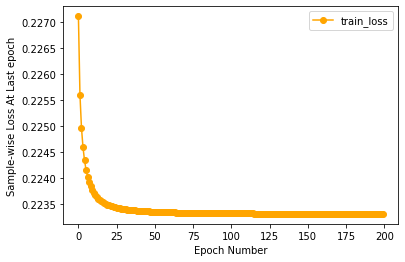

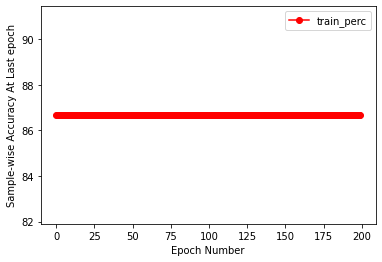

In [85]:
## Hyperparameters
EPOCH = 200
LR = 0.01 ##TODO: Choose a Learning Rate

## Setting up the model, optimizer, and loss function
model = CNNet()
if gpu_boole:
  model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr = LR) ##TODO: Choose an optimized
loss_f = nn.CrossEntropyLoss() ##TODO: Choose a loss

## Run Training Loop
train_cnn(model=model, optimizer=optimizer, loss_metric=loss_f, epochs=EPOCH, lr=LR)


In [86]:
y = df_test['outcome'].to_numpy()
len(y)

68

In [90]:
def eval1(loader):
    '''
    This function caculate for accuracy and loss. 
    Code reference: 601.482/682 Deep Learning L9
    '''

    pred = []
    y = []
    n = 0
    for images, labels in loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = torch.dstack((images,images))
        images = images.permute(2,0,1)
        outputs = model(images)
        print(outputs)
        # Prediction should choose the index of the max element in the outputs as the index
        value, predicted = torch.max(outputs.data, 1)
        predicted =  predicted.numpy()
        labels = labels.numpy()
        value = value.numpy()
        n = n+1
        if labels.sum() == 0:
            y.append(0)
        elif labels.sum() == 1:
            y.append(1)

        if predicted.sum() == 0:
            pred.append(value[0])
        elif predicted.sum() == 2:
            pred.append(1-value[0])
        
    return pred,y

In [91]:
def softmax(y_hat):
    """
    Softmax computation
    
    Args:
        y_hat (2d-list): 2-dimensional list of Values with shape [batch_size, n_class]
    
    Returns:
        s (2d-list): 2-dimensional list of Values with the same shape as y_hat    
    """
    #TODO implement the softmax function and return the output.
    
    s = []
    for i in range(len(y_hat)):
        y_i = []
        y_hat_sum = Value(0)
        for j in range(len(y_hat[i])):
            y_hat_sum += y_hat[i][j].exp()
            y_i.append(y_hat[i][j].exp())
            y_s = np.array(y_i)/y_hat_sum
        s.append(y_s.tolist())
    return s

In [92]:
pred,y = eval1(test_dataloader)
pred = np.array(pred)
y = np.array(y)
pred

tensor([[1.0000e+00, 2.5342e-19],
        [1.0000e+00, 2.5342e-19]], grad_fn=<SoftmaxBackward0>)
tensor([[1.0000e+00, 2.2334e-17],
        [1.0000e+00, 2.2334e-17]], grad_fn=<SoftmaxBackward0>)
tensor([[1.0000e+00, 5.0213e-07],
        [1.0000e+00, 5.0213e-07]], grad_fn=<SoftmaxBackward0>)
tensor([[1.0000e+00, 7.1975e-17],
        [1.0000e+00, 7.1975e-17]], grad_fn=<SoftmaxBackward0>)
tensor([[1.0000e+00, 1.5392e-08],
        [1.0000e+00, 1.5392e-08]], grad_fn=<SoftmaxBackward0>)
tensor([[1.0000e+00, 2.8701e-07],
        [1.0000e+00, 2.8701e-07]], grad_fn=<SoftmaxBackward0>)
tensor([[1.0000e+00, 4.0958e-24],
        [1.0000e+00, 4.0958e-24]], grad_fn=<SoftmaxBackward0>)
tensor([[1.0000e+00, 5.1976e-07],
        [1.0000e+00, 5.1976e-07]], grad_fn=<SoftmaxBackward0>)
tensor([[1.0000e+00, 1.4908e-06],
        [1.0000e+00, 1.4908e-06]], grad_fn=<SoftmaxBackward0>)
tensor([[9.9995e-01, 5.0783e-05],
        [9.9995e-01, 5.0783e-05]], grad_fn=<SoftmaxBackward0>)
tensor([[1.0000e+00, 1.0684e-0

/var/folders/p2/_cpbt8d53dz89l4n1hs72r8h0000gn/T/ipykernel_6629/140838028.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.sof(out)


array([1.        , 1.        , 0.9999995 , 1.        , 1.        ,
       0.99999976, 1.        , 0.9999995 , 0.99999845, 0.9999492 ,
       0.9999989 , 0.9999689 , 0.9995276 , 0.99999666, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.9999989 ,
       1.        , 1.        , 0.9999386 , 1.        , 1.        ,
       1.        , 1.        , 0.99999964, 1.        , 0.9999994 ,
       1.        , 0.9999622 , 1.        , 1.        ], dtype=float32)

ROC AUC=0.601


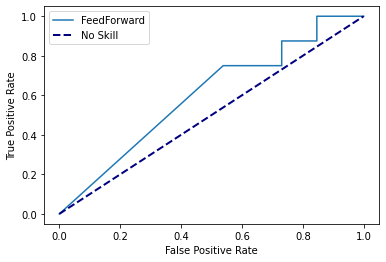

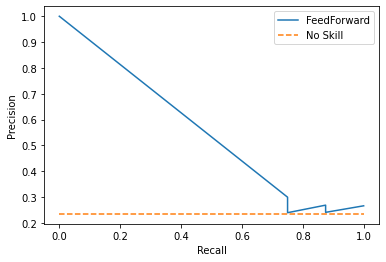

In [82]:
draw(y,pred)